In [126]:
import matplotlib.pyplot as plot
import pandas as pd

In [127]:
data_directory = '../raw/'

school_df = pd \
    .read_csv( f'{data_directory}/pubschls.txt', sep = '\t' ) \
    [lambda _df: _df['County'] == 'San Francisco'] \
    [lambda _df: _df['School'] != 'No Data']

enrollment_df = pd.DataFrame()
data_filenames = [ f'enr{yyyyyy}.txt' for yyyyyy in [ '200713-v3', '201416-v2', '201719-v2', '202022-v2' ] ]
for data_filename in data_filenames:
    enrollment_df = pd.concat(
        [
            enrollment_df,
            pd
                .read_csv( f'{data_directory}/{data_filename}', sep = '\t' )
                .merge( school_df[['CDSCode','School']], left_on = ['CDS_CODE'], right_on = ['CDSCode'] )
        ],
        axis = 0,
        ignore_index = True
    )

census_day_df = pd.DataFrame()
census_day_filenames = [ f'cdenroll{yyyy}' for yyyy in [ '2324-v2.txt', '2425.txt' ] ]
for data_filename in census_day_filenames:
    census_day_df = pd.concat(
        [
            census_day_df,
            pd
                .read_csv( f'{data_directory}/{data_filename}', sep = '\t', encoding = 'latin1', low_memory = False )
                [lambda _df: _df['CountyName'] == 'San Francisco']
        ],
        axis = 0,
        ignore_index = True
    )

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_33958/1790246715.py:15: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  .read_csv( f'{data_directory}/{data_filename}', sep = '\t' )


In [128]:
gender_map = {
    'F': 'Female',
    'M': 'Male',
    'X': 'Non-binary',
    'Z': 'Unknown'
}
race_ethnicity_map = {
    0: 'Not Reported',
    1: 'American Indian or Alaska Native',
    2: 'Asian',
    3: 'Pacific Islander',
    4: 'Filipino',
    5: 'Hispanic or Latino',
    6: 'African American',
    7: 'White',
    9: 'Two or More Races'
}

summary_df = enrollment_df \
    [lambda _df: _df['ENR_TYPE'].fillna( 'P' ) == 'P'] \
    .assign( RACE_ETHNICITY = lambda _df: _df.RACE_ETHNICITY.map( race_ethnicity_map ) ) \
    .assign( GENDER = lambda _df: _df.GENDER.map( gender_map ) ) \
    [['ACADEMIC_YEAR','CDS_CODE','SCHOOL','RACE_ETHNICITY','GENDER','ENR_TOTAL']] \
    .drop( 'GENDER', axis = 1 ) \
    .groupby( ['ACADEMIC_YEAR','CDS_CODE','SCHOOL','RACE_ETHNICITY'], as_index = False ) \
    .sum() \
    .assign( pct = lambda _df: _df['ENR_TOTAL'] / _df.groupby( ['ACADEMIC_YEAR','CDS_CODE','SCHOOL'] )['ENR_TOTAL'].transform( 'sum' ) )

In [129]:
census_day_race_ethnicity_map = {
    'RE_A': 'Asian',
    'RE_B': 'African American',
    'RE_D': 'Not Reported',
    'RE_F': 'Filipino',
    'RE_H': 'Hispanic or Latino',
    'RE_I': 'American Indian or Alaska Native',
    'RE_P': 'Pacific Islander',
    'RE_T': 'Two or More Races',
    'RE_W': 'White'
}

census_day_df = census_day_df \
    [lambda _df: _df['AggregateLevel'] == 'S'] \
    [['AcademicYear','SchoolCode','SchoolName','ReportingCategory','TOTAL_ENR']] \
    .assign( ReportingCategory = lambda _df: _df.ReportingCategory.map( census_day_race_ethnicity_map ) ) \
    [lambda _df: ~pd.isnull( _df['ReportingCategory'] ) ] \
    .assign( pct = lambda _df: _df['TOTAL_ENR'] / _df.groupby( ['AcademicYear','SchoolCode','SchoolName'] )['TOTAL_ENR'].transform( 'sum' ) ) \
    [lambda _df: ~pd.isnull( _df['SchoolCode'] )] \
    .rename( columns = {
        'AcademicYear': 'ACADEMIC_YEAR',
        'SchoolCode': 'CDS_CODE',
        'SchoolName': 'SCHOOL',
        'ReportingCategory': 'RACE_ETHNICITY'
    } )

In [130]:

pivot_sum_df_historical = summary_df \
    .pivot( index = [ 'ACADEMIC_YEAR','CDS_CODE','SCHOOL'], columns = ['RACE_ETHNICITY'], values = ['ENR_TOTAL'] ) \
    .fillna( 0 ) \
    .reset_index()
pivot_sum_df_census_day = census_day_df \
    .pivot( index = [ 'ACADEMIC_YEAR','CDS_CODE','SCHOOL'], columns = ['RACE_ETHNICITY'], values = ['TOTAL_ENR'] ) \
    .fillna( 0 ) \
    .reset_index()
pivot_sum_df_historical.columns = [ col[0] if col[1] == '' else col[1] for col in pivot_sum_df_historical.columns.values ]
pivot_sum_df_census_day.columns = [ col[0] if col[1] == '' else col[1] for col in pivot_sum_df_census_day.columns.values ]
pivot_sum_df = pd.concat( [ pivot_sum_df_historical, pivot_sum_df_census_day])
pivot_sum_df.to_csv( './sfusd-school-ethnicity-sum.csv', index = False )

pivot_pct_df_historical = summary_df \
    .pivot( index = [ 'ACADEMIC_YEAR','CDS_CODE','SCHOOL'], columns = ['RACE_ETHNICITY'], values = ['pct'] ) \
    .fillna( 0 ) \
    .reset_index()
pivot_pct_df_historical.columns = [ col[0] if col[1] == '' else col[1] for col in pivot_pct_df_historical.columns.values ]
pivot_pct_df_census_day = census_day_df \
    .pivot( index = [ 'ACADEMIC_YEAR','CDS_CODE','SCHOOL'], columns = ['RACE_ETHNICITY'], values = ['pct'] ) \
    .fillna( 0 ) \
    .reset_index()
pivot_pct_df_census_day.columns = [ col[0] if col[1] == '' else col[1] for col in pivot_pct_df_census_day.columns.values ]
pivot_pct_df = pd.concat( [ pivot_pct_df_historical, pivot_pct_df_census_day])
pivot_pct_df.to_csv( './sfusd-school-ethnicity-pct.csv', index = False )

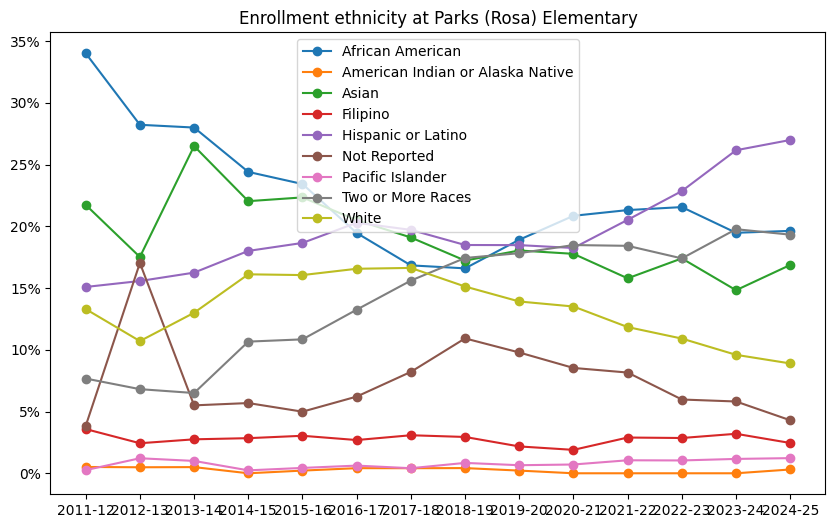

In [131]:
#
# Show for a given school
#
school_prefix = 'Parks'

plot_df = pivot_pct_df \
    [pivot_pct_df['SCHOOL'].str.startswith( school_prefix )] \
    .drop( ['CDS_CODE'], axis = 1 ) \
    .sort_values( 'ACADEMIC_YEAR' )

figure, axes = plot.subplots( figsize = ( 10, 6 ) )
for eth in plot_df.columns:
    if eth in [ 'ACADEMIC_YEAR', 'CDS_CODE', 'SCHOOL' ]:
        continue

    axes.plot( plot_df['ACADEMIC_YEAR'], plot_df[eth], marker = 'o', label = eth )
axes.legend( loc = 'best')
axes.set_title( f"Enrollment ethnicity at {plot_df['SCHOOL'].iloc[0]}" )
axes.yaxis.set_major_formatter( '{x:0.0%}' )

plot.show()

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_33958/2189838579.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels( xticklabels, rotation = 30, ha = 'right' )


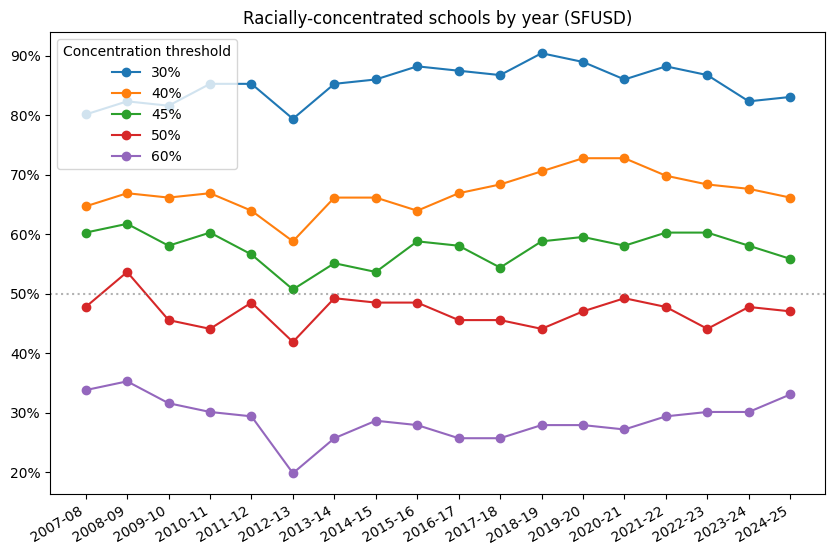

In [144]:
concentration_df = pd.concat(
        [
            summary_df.groupby( [ 'ACADEMIC_YEAR', 'SCHOOL' ], as_index = False )['pct'].max(),
            census_day_df.groupby( [ 'ACADEMIC_YEAR', 'SCHOOL' ], as_index = False )['pct'].max()
        ],
        axis = 0,
        ignore_index = True
    ) \
    [lambda _df: ~_df['SCHOOL'].isin( [ 'District Office', 'Lawton Alternative', 'Nonpublic, Nonsectarian Schools'] )] \
    .assign( count = lambda _df: _df[_df['ACADEMIC_YEAR'] >= '2016-17'].SCHOOL.nunique() )



figure, axes = plot.subplots( figsize = ( 10, 6 ) )

for concentration_threshold in [ 30, 40, 45, 50, 60 ]:
    concentration_threshold /= 100.0
    plot_df = concentration_df \
        .assign( above_threshold = lambda _df: _df['pct'] >= concentration_threshold ) \
        [lambda _df: _df.above_threshold ] \
        .groupby( [ 'ACADEMIC_YEAR', 'count' ], as_index = False )['above_threshold'] \
        .count()
    
    axes.plot( plot_df['ACADEMIC_YEAR'], plot_df['above_threshold'] / plot_df['count'], marker = 'o', label = f'{concentration_threshold:0.0%}' )

axes.legend( title = 'Concentration threshold', loc = 'best' )
axes.yaxis.set_major_formatter( '{x:0.0%}' )
axes.set_title( 'Racially-concentrated schools by year (SFUSD)' )
axes.axhline( 0.5, linestyle = 'dotted', color = 'gray', alpha = 0.6 )

plot.draw()
xticklabels = axes.get_xticklabels()
axes.set_xticklabels( xticklabels, rotation = 30, ha = 'right' )

plot.show()

In [143]:
# sorted( pd.concat(
#         [
#             summary_df.groupby( [ 'ACADEMIC_YEAR', 'SCHOOL' ], as_index = False )['pct'].max(),
#             census_day_df.groupby( [ 'ACADEMIC_YEAR', 'SCHOOL' ], as_index = False )['pct'].max()
#         ],
#         axis = 0,
#         ignore_index = True
#     ) \
#     [lambda _df: ~_df['SCHOOL'].isin( [ 'District Office', 'Lawton Alternative', 'Nonpublic, Nonsectarian Schools'] )] \
#     .SCHOOL.unique() )

plot_df

,ACADEMIC_YEAR,count,above_threshold
